# The transfer study

## Init

In [4]:
from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import gymnasium as gym
from sb3_contrib import TQC
from huggingface_sb3 import load_from_hub

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

from pipoli.core import DimensionalPolicy, Dimension, Context, Policy
from pipoli.sources.sb3 import SB3Policy
from pipoli.evaluation import linsweep_change_contexts, linsweep_scale_contexts, scale_sweep_volume_bounds, record_sweep

from make_cheetah import make_cheetah, make_cheetah_xml

In [5]:
ROOT = Path() / "output"
XML_FILES = ROOT / "xml_files"
DATA = ROOT / "data"

In [6]:
class NaiveObsScaledActPolicy(Policy):

    def __init__(self, dim_pol, context, base):
        self.dim_pol = dim_pol
        self.context = context
        self.base = base
        act_dims = dim_pol.act_dims
        self.orig_to_adim, _ = dim_pol.context.make_transforms(act_dims, base)
        _, self.adim_to_scale = context.make_transforms(act_dims, base)
    
    def action(self, obs):
        """Scale only the action from a naive observation.
        
        Usually, the actuators of a system are sized accordingly. It would be
        unfair to not allow the policy to use the full range or allow it to use to much.
        """
        orig_act = self.dim_pol.action(obs)
        adim_act = self.orig_to_adim(orig_act)
        scaled_act = self.adim_to_scale(adim_act)
        return scaled_act

In [7]:
def make_env(context):
    torso_pos_z = context.value("torso_pos_z")
    xml_file = make_cheetah_xml(context, torso_pos_z, "env", outdir=XML_FILES)

    forward_weight = context.value("forward_reward_weight")
    ctrl_weight = context.value("ctrl_cost_weight")

    env = gym.make(
        "HalfCheetah-v5",
        xml_file=xml_file,
        forward_reward_weight=forward_weight,
        ctrl_cost_weight=ctrl_weight,
        reset_noise_scale=0,
    )
    
    return env

## Parameters

### Original context and policy

In [8]:
BASE_DIMENSIONS = [
    M := Dimension([1, 0, 0]),
    L := Dimension([0, 1, 0]),
    T := Dimension([0, 0, 1]),
]
Unit = Dimension([0, 0, 0])

In [9]:
original_context = Context.from_quantities(
    dt = 0.01                   | T,
    m = 14                      | M,
    g = 9.81                    | L/T**2,
    taumax = 1                  | M*L**2/T**2,
    d = 0.046                   | L,
    L = 0.5                     | L,
    Lh = 0.15                   | L,
    l0 = 0.145                  | L,
    l1 = 0.15                   | L,
    l2 = 0.094                  | L,
    l3 = 0.133                  | L,
    l4 = 0.106                  | L,
    l5 = 0.07                   | L,
    k0 = 240                    | M*L**2/T**2,
    k1 = 180                    | M*L**2/T**2,
    k2 = 120                    | M*L**2/T**2,
    k3 = 180                    | M*L**2/T**2,
    k4 = 120                    | M*L**2/T**2,
    k5 = 60                     | M*L**2/T**2,
    b0 = 6                      | M*L**2/T,
    b1 = 4.5                    | M*L**2/T,
    b2 = 3                      | M*L**2/T,
    b3 = 4.5                    | M*L**2/T,
    b4 = 3                      | M*L**2/T,
    b5 = 1.5                    | M*L**2/T,
    armature = 0.1              | M*L**2,
    damping = 0.01              | M*L**2/T,
    stiffness = 8               | M*L**2/T**2,
    forward_reward_weight = 1   | T/L,
    ctrl_cost_weight = 0.1      | T**4/M**2/L**4,
    torso_pos_z = 0.7           | L,
)

In [10]:
halfcheetah_v5_tqc_expert =  load_from_hub(
    repo_id="farama-minari/HalfCheetah-v5-TQC-expert",
    filename="halfcheetah-v5-TQC-expert.zip",
)
model = TQC.load(halfcheetah_v5_tqc_expert, device="cpu")

sb3_policy = SB3Policy(
    model,
    model_obs_space=gym.spaces.Box(-np.inf, np.inf, (17,), np.float64),
    model_act_space=gym.spaces.Box(-1.0, 1.0, (6,), np.float32),
    predict_kwargs=dict(deterministic=True)
)

original_policy = DimensionalPolicy(
    sb3_policy,
    original_context,
    obs_dims=[L] + [Unit] * 7 + [L/T] * 2 + [1/T] * 7,
    act_dims=[M*L**2/T**2] * 6
)

/home/pasf3302/Dev/transfer_halfcheetah/.venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(


### Sweeps

In [11]:
base = ["m", "l0", "g"]
scale = 2
resolution = 50

similar_sweep_desc = dict(
    m = (14 / scale, 14 * scale, resolution),
    l0 = (0.145 / scale, 0.145 * scale, resolution),
    g = (9.81, 9.81, 1),
)

quasi_same_sweep_desc = dict(
    m = (14 / scale, 14 * scale, resolution),
    taumax = (1 / scale, 1 * scale, resolution),
)

quasi_similar_1_scale_sweep_desc = dict(
    m = (14 / scale, 14 * scale, resolution),
    l0 = (0.145, 0.145, 1),
    g = (9.81, 9.81, 1),
)
quasi_similar_1_change_sweep_desc = dict(
    taumax = (1 / scale, 1 * scale, resolution),
)

quasi_similar_2_scale_sweep_desc = dict(
    m = (14, 14, 1),
    l0 = (0.145 / scale, 0.145 * scale, resolution),
    g = (9.81, 9.81, 1),
)
quasi_similar_2_change_sweep_desc = dict(
    L = (0.5 / scale, 0.5 * scale, resolution),
)

nb_random_contexts = resolution * resolution

# bounds factors for random contexts around the original context
upper, lower = scale_sweep_volume_bounds(original_context, similar_sweep_desc)

upper /= original_context.values
lower /= original_context.values

upper[np.isnan(upper)] = 0
lower[np.isnan(lower)] = 0

### Functions

In [12]:
def make_scaled_policy(context):
    policy = original_policy.to_scaled(context, base)
    return policy

def make_semi_scaled_policy(context):
    policy = NaiveObsScaledActPolicy(original_policy, context, base)
    return policy

def make_naive_policy(_context):
    return original_policy

In [13]:
def ep_fn_extract_reward(act, step_res, _step):
    obs, rew, _, _, info = step_res

    fwd_rew = info["reward_forward"]
    ctrl_rew = info["reward_ctrl"]

    is_flipped = abs(obs[1]) > np.pi / 1.8

    return rew, fwd_rew, ctrl_rew, is_flipped

def ep_reduce_fn_total_reward(steps):
    nb_steps = len(steps)
    rews = np.zeros(nb_steps)
    fwds = np.zeros(nb_steps)
    ctrls = np.zeros(nb_steps)
    are_flipped = np.zeros(nb_steps, dtype=bool)

    for i, (rew, fwd, ctrl, is_flipped) in enumerate(steps):
        rews[i] = rew
        fwds[i] = fwd
        ctrls[i] = ctrl
        are_flipped[i] = is_flipped

    return rews.sum(), fwds.sum(), ctrls.sum(), int(any(are_flipped))

def fuse_fn(context_rec, ep_rec):
    _, _, reduction = ep_rec

    return context_rec + reduction

### Metadata

In [14]:
common_metadata = dict(
    base=base,
    original_context=original_context,
    original_policy=dict(
        repo_id="farama-minari/HalfCheetah-v5-TQC-expert",
        filename="halfcheetah-v5-TQC-expert.zip",
    ),
    env="HalfCheetah-v5",
)

## Similar transfer

### Data generation

In [12]:
def context_fn(context):
    b1 = context.value(base[0])
    b2 = context.value(base[1])
    b3 = context.value(base[2])
    distance = context.adimensional_distance(original_context, base)

    return context, b1, b2, b3, distance

In [13]:
all_similar_contexts = linsweep_scale_contexts(original_context, similar_sweep_desc)

In [14]:
columns = ["context", base[0], base[1], base[2], "distance", "reward", "fwd_reward", "ctrl_reward", "is_flipped"]

#### Scaled

In [15]:
data_scaled = record_sweep(
    all_similar_contexts,
    make_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
similar_scaled_df = pd.DataFrame(columns=columns, data=data_scaled)
similar_scaled_df

context     m        l0     g  \
0     ((L, Dimension([0 1 0]), 0.25), (Lh, Dimension...   7.0  0.072500  9.81   
1     ((L, Dimension([0 1 0]), 0.2653061224489796), ...   7.0  0.076939  9.81   
2     ((L, Dimension([0 1 0]), 0.28061224489795916),...   7.0  0.081378  9.81   
3     ((L, Dimension([0 1 0]), 0.2959183673469387), ...   7.0  0.085816  9.81   
4     ((L, Dimension([0 1 0]), 0.3112244897959184), ...   7.0  0.090255  9.81   
...                                                 ...   ...       ...   ...   
2495  ((L, Dimension([0 1 0]), 0.9387755102040817), ...  28.0  0.272245  9.81   
2496  ((L, Dimension([0 1 0]), 0.9540816326530611), ...  28.0  0.276684  9.81   
2497  ((L, Dimension([0 1 0]), 0.9693877551020408), ...  28.0  0.281122  9.81   
2498  ((L, Dimension([0 1 0]), 0.9846938775510202), ...  28.0  0.285561  9.81   
2499  ((L, Dimension([0 1 0]), 1.0), (Lh, Dimension(...  28.0  0.290000  9.81   

          distance        reward    fwd_reward  ctrl_reward  is_flipped  
0     0.000000e+00  16386.372012  16745.085131  -358.713119           0  
1     4.577567e-16  16386.372011  16745.085132  -358.713122           0  
2     0.000000e+00  16386.371972  16745.085094  -358.713121           0  
3     4.577567e-16  16386.372052  16745.085173  -358.713122           0  
4     1.671107e-16  16386.371979  16745.085106  -358.713127           0  
...            ...           ...           ...          ...         ...  
2495  0.000000e+00  16386.371914  16745.085033  -358.713120           0  
2496  3.188873e-16  16386.371924  16745.085044  -358.713120           0  
2497  5.551115e-17  16386.371921  16745.085038  -358.713116           0  
2498  0.000000e+00  16386.371857  16745.084980  -358.713124           0  
2499  0.000000e+00  16386.372012  16745.085131  -358.713119           0  

[2500 rows x 9 columns]

In [16]:
similar_scaled_df.to_pickle(DATA / "similar_scaled.pkl.gz")

#### Semi scaled

In [17]:
data_semi_scaled = record_sweep(
    all_similar_contexts,
    make_semi_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
similar_semi_scaled_df = pd.DataFrame(columns=columns, data=data_semi_scaled)
similar_semi_scaled_df

context     m        l0     g  \
0     ((L, Dimension([0 1 0]), 0.25), (Lh, Dimension...   7.0  0.072500  9.81   
1     ((L, Dimension([0 1 0]), 0.2653061224489796), ...   7.0  0.076939  9.81   
2     ((L, Dimension([0 1 0]), 0.28061224489795916),...   7.0  0.081378  9.81   
3     ((L, Dimension([0 1 0]), 0.2959183673469387), ...   7.0  0.085816  9.81   
4     ((L, Dimension([0 1 0]), 0.3112244897959184), ...   7.0  0.090255  9.81   
...                                                 ...   ...       ...   ...   
2495  ((L, Dimension([0 1 0]), 0.9387755102040817), ...  28.0  0.272245  9.81   
2496  ((L, Dimension([0 1 0]), 0.9540816326530611), ...  28.0  0.276684  9.81   
2497  ((L, Dimension([0 1 0]), 0.9693877551020408), ...  28.0  0.281122  9.81   
2498  ((L, Dimension([0 1 0]), 0.9846938775510202), ...  28.0  0.285561  9.81   
2499  ((L, Dimension([0 1 0]), 1.0), (Lh, Dimension(...  28.0  0.290000  9.81   

          distance       reward   fwd_reward  ctrl_reward  is_flipped  
0     0.000000e+00   645.090785   810.297935  -165.207150           1  
1     4.577567e-16   959.101864  1078.195838  -119.093974           1  
2     0.000000e+00  3379.922409  3762.447459  -382.525049           1  
3     4.577567e-16  3609.755219  3993.118514  -383.363294           0  
4     1.671107e-16   721.344526   785.568074   -64.223548           1  
...            ...          ...          ...          ...         ...  
2495  0.000000e+00   322.089018   747.484331  -425.395313           0  
2496  3.188873e-16   236.587491   656.657316  -420.069825           0  
2497  5.551115e-17   214.129397   633.500127  -419.370730           0  
2498  0.000000e+00   164.713622   588.449123  -423.735501           0  
2499  0.000000e+00  -442.511453    14.548897  -457.060350           0  

[2500 rows x 9 columns]

In [18]:
similar_semi_scaled_df.to_pickle(DATA / "similar_semi_scaled.pkl.gz")

#### Naive

In [19]:
data_naive = record_sweep(
    all_similar_contexts,
    make_naive_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
similar_naive_df = pd.DataFrame(columns=columns, data=data_naive)
similar_naive_df

context     m        l0     g  \
0     ((L, Dimension([0 1 0]), 0.25), (Lh, Dimension...   7.0  0.072500  9.81   
1     ((L, Dimension([0 1 0]), 0.2653061224489796), ...   7.0  0.076939  9.81   
2     ((L, Dimension([0 1 0]), 0.28061224489795916),...   7.0  0.081378  9.81   
3     ((L, Dimension([0 1 0]), 0.2959183673469387), ...   7.0  0.085816  9.81   
4     ((L, Dimension([0 1 0]), 0.3112244897959184), ...   7.0  0.090255  9.81   
...                                                 ...   ...       ...   ...   
2495  ((L, Dimension([0 1 0]), 0.9387755102040817), ...  28.0  0.272245  9.81   
2496  ((L, Dimension([0 1 0]), 0.9540816326530611), ...  28.0  0.276684  9.81   
2497  ((L, Dimension([0 1 0]), 0.9693877551020408), ...  28.0  0.281122  9.81   
2498  ((L, Dimension([0 1 0]), 0.9846938775510202), ...  28.0  0.285561  9.81   
2499  ((L, Dimension([0 1 0]), 1.0), (Lh, Dimension(...  28.0  0.290000  9.81   

          distance       reward   fwd_reward  ctrl_reward  is_flipped  
0     0.000000e+00  -544.605548     2.923786  -547.529334           1  
1     4.577567e-16  -894.764443   903.143138 -1797.907581           1  
2     0.000000e+00  -915.676883   411.726790 -1327.403673           1  
3     4.577567e-16 -1518.703724  1428.372787 -2947.076511           1  
4     1.671107e-16  -494.600296   563.487987 -1058.088284           1  
...            ...          ...          ...          ...         ...  
2495  0.000000e+00   -25.278238    -0.027393   -25.250845           0  
2496  3.188873e-16   -24.871473    -0.403685   -24.467787           0  
2497  5.551115e-17   -23.733157    -0.311101   -23.422057           0  
2498  0.000000e+00   -22.861696    -0.355489   -22.506208           0  
2499  0.000000e+00   -22.056938    -0.387160   -21.669778           0  

[2500 rows x 9 columns]

In [20]:
similar_naive_df.to_pickle(DATA / "similar_naive.pkl.gz")

### Analysis

In [21]:
similar_scaled_df = pd.read_pickle(DATA / "similar_scaled.pkl.gz")
similar_semi_scaled_df = pd.read_pickle(DATA / "similar_semi_scaled.pkl.gz")
similar_naive_df = pd.read_pickle(DATA / "similar_naive.pkl.gz")

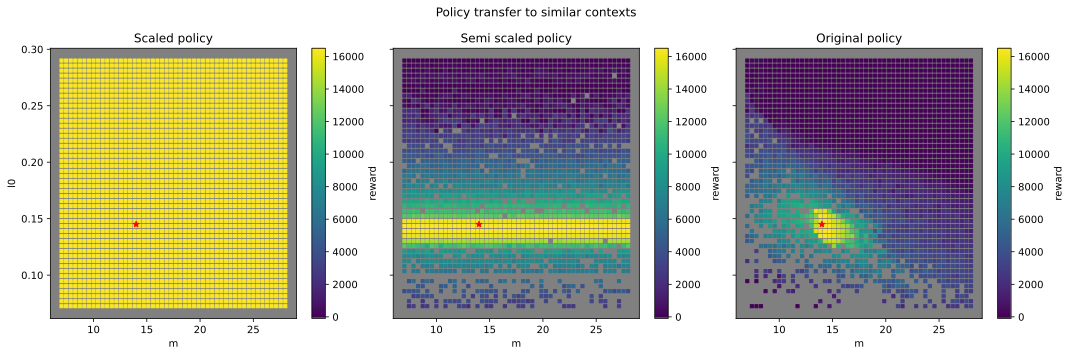

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

m0 = original_context.value("m")
l0 = original_context.value("l0")

norm = mpl.colors.Normalize(vmin=-100, vmax=16500)

similar_scaled_df.loc[similar_scaled_df["is_flipped"] == 0].plot.scatter("m", "l0", c="reward", marker="s", s=10, norm=norm, ax=ax1)
# similar_scaled_df.plot.scatter("m", "l0", c="reward", marker="s", s=50, norm=norm, ax=ax1)
ax1.scatter(m0, l0, marker="*", c="r")
ax1.set_title("Scaled policy")
ax1.set_facecolor("grey")

similar_semi_scaled_df.loc[similar_semi_scaled_df["is_flipped"] == 0].plot.scatter("m", "l0", c="reward", marker="s", s=10, norm=norm, ax=ax2)
# similar_semi_scaled_df.plot.scatter("m", "l0", c="reward", marker="s", s=50, norm=norm, ax=ax2)
ax2.scatter(m0, l0, marker="*", c="r")
ax2.set_title("Semi scaled policy")
ax2.set_facecolor("grey")

similar_naive_df.loc[similar_naive_df["is_flipped"] == 0].plot.scatter("m", "l0", c="reward", marker="s", s=10, norm=norm, ax=ax3)
# similar_naive_df.plot.scatter("m", "l0", c="reward", marker="s", s=50, norm=norm, ax=ax3)
ax3.scatter(m0, l0, marker="*", c="r")
ax3.set_title("Original policy")
ax3.set_facecolor("grey")

fig.suptitle("Policy transfer to similar contexts")
fig.set_tight_layout(True)

In [23]:
similar_scaled_df

context     m        l0     g  \
0     ((L, Dimension([0 1 0]), 0.25), (Lh, Dimension...   7.0  0.072500  9.81   
1     ((L, Dimension([0 1 0]), 0.2653061224489796), ...   7.0  0.076939  9.81   
2     ((L, Dimension([0 1 0]), 0.28061224489795916),...   7.0  0.081378  9.81   
3     ((L, Dimension([0 1 0]), 0.2959183673469387), ...   7.0  0.085816  9.81   
4     ((L, Dimension([0 1 0]), 0.3112244897959184), ...   7.0  0.090255  9.81   
...                                                 ...   ...       ...   ...   
2495  ((L, Dimension([0 1 0]), 0.9387755102040817), ...  28.0  0.272245  9.81   
2496  ((L, Dimension([0 1 0]), 0.9540816326530611), ...  28.0  0.276684  9.81   
2497  ((L, Dimension([0 1 0]), 0.9693877551020408), ...  28.0  0.281122  9.81   
2498  ((L, Dimension([0 1 0]), 0.9846938775510202), ...  28.0  0.285561  9.81   
2499  ((L, Dimension([0 1 0]), 1.0), (Lh, Dimension(...  28.0  0.290000  9.81   

          distance        reward    fwd_reward  ctrl_reward  is_flipped  
0     0.000000e+00  16386.372012  16745.085131  -358.713119           0  
1     4.577567e-16  16386.372011  16745.085132  -358.713122           0  
2     0.000000e+00  16386.371972  16745.085094  -358.713121           0  
3     4.577567e-16  16386.372052  16745.085173  -358.713122           0  
4     1.671107e-16  16386.371979  16745.085106  -358.713127           0  
...            ...           ...           ...          ...         ...  
2495  0.000000e+00  16386.371914  16745.085033  -358.713120           0  
2496  3.188873e-16  16386.371924  16745.085044  -358.713120           0  
2497  5.551115e-17  16386.371921  16745.085038  -358.713116           0  
2498  0.000000e+00  16386.371857  16745.084980  -358.713124           0  
2499  0.000000e+00  16386.372012  16745.085131  -358.713119           0  

[2500 rows x 9 columns]

## Quasi same transfer

### Data generation

In [24]:
def context_fn(context):
    b1 = context.value(base[0])
    b2 = context.value(base[1])
    b3 = context.value(base[2])
    distance = context.adimensional_distance(original_context, base)

    change = []
    for sym in quasi_same_sweep_desc.keys():
        if sym not in base:
            change.append(context.value(sym))

    return context, b1, b2, b3, *change, distance

In [25]:
changed_symbols = []
for sym in quasi_same_sweep_desc.keys():
    if sym not in base:
        changed_symbols.append(sym)

columns = ["context", base[0], base[1], base[2], *changed_symbols, "distance", "reward", "fwd_reward", "ctrl_reward", "is_flipped"]

In [26]:
all_quasi_same_contexts = linsweep_change_contexts(original_context, quasi_same_sweep_desc)

#### Scaled

In [27]:
data_scaled = record_sweep(
    all_quasi_same_contexts,
    make_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_same_scaled_df = pd.DataFrame(columns=columns, data=data_scaled)
quasi_same_scaled_df

context     m     l0     g  \
0     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
1     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
2     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
3     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
4     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
...                                                 ...   ...    ...   ...   
2495  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2496  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2497  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2498  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2499  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   

        taumax    distance       reward   fwd_reward  ctrl_reward  is_flipped  
0     0.500000   35.941521  1853.294014  1947.498279   -94.204265           0  
1     0.530612   35.941521  1853.294014  1947.498279   -94.204265           0  
2     0.561224   35.941522  1853.294014  1947.498279   -94.204265           0  
3     0.591837   35.941522  1853.294014  1947.498279   -94.204265           0  
4     0.622449   35.941523  1853.294014  1947.498279   -94.204265           0  
...        ...         ...          ...          ...          ...         ...  
2495  1.877551  119.400779  2071.880828  2803.207325  -731.326497           1  
2496  1.908163  119.400779  2746.431843  4101.275274 -1354.843431           1  
2497  1.938776  119.400779  4012.367344  5616.367145 -1603.999801           0  
2498  1.969388  119.400778   803.209859  1268.410436  -465.200577           1  
2499  2.000000  119.400778  3854.494819  5446.818360 -1592.323541           0  

[2500 rows x 10 columns]

In [28]:
quasi_same_scaled_df.to_pickle(DATA / "quasi_same_scaled.pkl.gz")

#### Semi scaled

In [29]:
data_semi_scaled = record_sweep(
    all_quasi_same_contexts,
    make_semi_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_same_semi_scaled_df = pd.DataFrame(columns=columns, data=data_semi_scaled)
quasi_same_semi_scaled_df

context     m     l0     g  \
0     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
1     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
2     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
3     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
4     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
...                                                 ...   ...    ...   ...   
2495  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2496  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2497  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2498  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2499  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   

        taumax    distance       reward   fwd_reward  ctrl_reward  is_flipped  
0     0.500000   35.941521  1853.294014  1947.498279   -94.204265           0  
1     0.530612   35.941521  1853.294014  1947.498279   -94.204265           0  
2     0.561224   35.941522  1853.294014  1947.498279   -94.204265           0  
3     0.591837   35.941522  1853.294014  1947.498279   -94.204265           0  
4     0.622449   35.941523  1853.294014  1947.498279   -94.204265           0  
...        ...         ...          ...          ...          ...         ...  
2495  1.877551  119.400779  2071.880828  2803.207325  -731.326497           1  
2496  1.908163  119.400779  2746.431843  4101.275274 -1354.843431           1  
2497  1.938776  119.400779  4012.367344  5616.367145 -1603.999801           0  
2498  1.969388  119.400778   803.209859  1268.410436  -465.200577           1  
2499  2.000000  119.400778  3854.494819  5446.818360 -1592.323541           0  

[2500 rows x 10 columns]

In [30]:
quasi_same_semi_scaled_df.to_pickle(DATA / "quasi_same_semi_scaled.pkl.gz")

#### Naive

In [57]:
data_naive = record_sweep(
    all_quasi_same_contexts,
    make_naive_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_same_naive_df = pd.DataFrame(columns=columns, data=data_naive)
quasi_same_naive_df

context     m     l0     g  \
0     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
1     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
2     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
3     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
4     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
...                                                 ...   ...    ...   ...   
2495  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2496  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2497  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2498  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2499  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   

        L    distance       reward   fwd_reward  ctrl_reward  is_flipped  
0     0.5   35.941521   253.333957   304.295605   -50.961648           1  
1     0.5   35.941521   541.477286   642.504096  -101.026809           1  
2     0.5   35.941522  3759.602142  4136.077118  -376.474975           0  
3     0.5   35.941522   396.080333   435.466781   -39.386448           1  
4     0.5   35.941523  3756.598906  4141.616955  -385.018048           0  
...   ...         ...          ...          ...          ...         ...  
2495  0.5  119.400779  3457.491988  3839.633672  -382.141684           0  
2496  0.5  119.400779  3457.491988  3839.633672  -382.141684           0  
2497  0.5  119.400779  3457.491988  3839.633672  -382.141684           0  
2498  0.5  119.400778  3457.491988  3839.633672  -382.141684           0  
2499  0.5  119.400778  3457.491988  3839.633672  -382.141684           0  

[2500 rows x 10 columns]

In [58]:
quasi_same_naive_df.to_pickle(DATA / "quasi_same_naive.pkl.gz")

### Analysis


In [3]:
quasi_same_scaled_df = pd.read_pickle(DATA / "quasi_same_scaled.pkl.gz")
quasi_same_semi_scaled_df = pd.read_pickle(DATA / "quasi_same_semi_scaled.pkl.gz")
quasi_same_naive_df = pd.read_pickle(DATA / "quasi_same_naive.pkl.gz")

NameError: name 'pd' is not defined

KeyError: 'taumax'

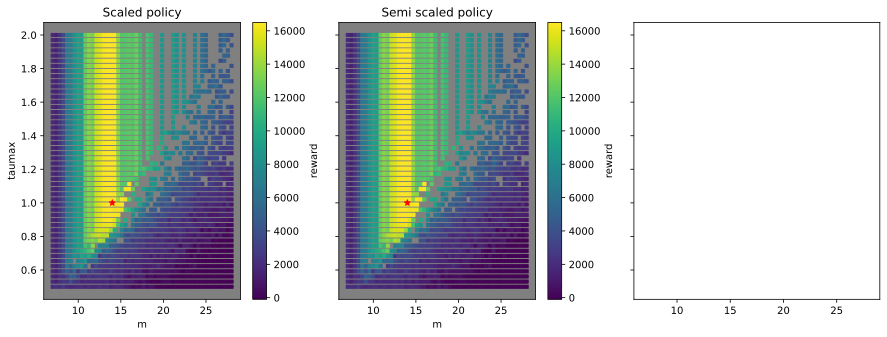

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

m0 = original_context.value("m")
tau0 = original_context.value("taumax")

norm = mpl.colors.Normalize(vmin=-100, vmax=16500)

quasi_same_scaled_df.loc[quasi_same_scaled_df["is_flipped"] == 0].plot.scatter("m", "taumax", c="reward", marker="s", s=10, norm=norm, ax=ax1)
# quasi_same_scaled_df.plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax1)
ax1.scatter(m0, tau0, marker="*", c="r")
ax1.set_title("Scaled policy")
ax1.set_facecolor("grey")

quasi_same_semi_scaled_df.loc[quasi_same_semi_scaled_df["is_flipped"] == 0].plot.scatter("m", "taumax", c="reward", marker="s", s=10, norm=norm, ax=ax2)
# quasi_same_semi_scaled_df.plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax2)
ax2.scatter(m0, tau0, marker="*", c="r")
ax2.set_title("Semi scaled policy")
ax2.set_facecolor("grey")

quasi_same_naive_df.loc[quasi_same_naive_df["is_flipped"] == 0].plot.scatter("m", "taumax", c="reward", marker="s", s=10, norm=norm, ax=ax3)
# quasi_same_naive_df.plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax3)
ax3.scatter(m0, tau0, marker="*", c="r")
ax3.set_title("Original policy")
ax3.set_facecolor("grey")

fig.suptitle("Policy transfer to quasi same contexts")
fig.set_tight_layout(True)

## Quasi similar transfer 1

### Data generation

In [35]:
def context_fn(context):
    b1 = context.value(base[0])
    b2 = context.value(base[1])
    b3 = context.value(base[2])
    distance = context.adimensional_distance(original_context, base)

    change = []
    for sym in quasi_similar_1_change_sweep_desc.keys():
        if sym not in base:
            change.append(context.value(sym))

    return context, b1, b2, b3, *change, distance

In [36]:
changed_symbols = []
for sym in quasi_similar_1_change_sweep_desc.keys():
    if sym not in base:
        changed_symbols.append(sym)

columns = ["context", base[0], base[1], base[2], *changed_symbols, "distance", "reward", "fwd_reward", "ctrl_reward", "is_flipped"]

In [37]:
# map change(taumax) linsweep_scale_contexts(mgl)
all_quasi_similar_1_contexts = []

similars = linsweep_scale_contexts(original_context, quasi_similar_1_scale_sweep_desc)
for context in similars:
    all_quasi_similar_1_contexts += linsweep_change_contexts(context, quasi_similar_1_change_sweep_desc)

#### Scaled

In [38]:
data_scaled = record_sweep(
    all_quasi_similar_1_contexts,
    make_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_similar_1_scaled_df = pd.DataFrame(columns=columns, data=data_scaled)
quasi_similar_1_scaled_df

context     m     l0     g  \
0     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
1     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
2     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
3     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
4     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
...                                                 ...   ...    ...   ...   
2495  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2496  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2497  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2498  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2499  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   

        taumax  distance        reward    fwd_reward  ctrl_reward  is_flipped  
0     0.500000  0.000000  16386.372043  16745.085166  -358.713122           0  
1     0.530612  0.003074  16386.372043  16745.085166  -358.713122           0  
2     0.561224  0.006149  16386.372043  16745.085166  -358.713122           0  
3     0.591837  0.009223  16386.372043  16745.085166  -358.713122           0  
4     0.622449  0.012298  16386.372043  16745.085166  -358.713122           0  
...        ...       ...           ...           ...          ...         ...  
2495  1.877551  0.003074  15551.732778  15920.290442  -368.557663           0  
2496  1.908163  0.002306  16819.602197  17183.053328  -363.451130           0  
2497  1.938776  0.001537  16379.104330  16737.840982  -358.736651           0  
2498  1.969388  0.000769  16385.734820  16744.456082  -358.721262           0  
2499  2.000000  0.000000  16386.372043  16745.085166  -358.713122           0  

[2500 rows x 10 columns]

In [39]:
quasi_similar_1_scaled_df.to_pickle(DATA / "quasi_similar_1_scaled.pkl.gz")

#### Semi scaled

In [40]:
data_semi_scaled = record_sweep(
    all_quasi_similar_1_contexts,
    make_semi_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_similar_1_semi_scaled_df = pd.DataFrame(columns=columns, data=data_semi_scaled)
quasi_similar_1_semi_scaled_df

context     m     l0     g  \
0     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
1     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
2     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
3     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
4     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
...                                                 ...   ...    ...   ...   
2495  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2496  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2497  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2498  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2499  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   

        taumax  distance        reward    fwd_reward  ctrl_reward  is_flipped  
0     0.500000  0.000000  16386.372043  16745.085166  -358.713122           0  
1     0.530612  0.003074  16386.372043  16745.085166  -358.713122           0  
2     0.561224  0.006149  16386.372043  16745.085166  -358.713122           0  
3     0.591837  0.009223  16386.372043  16745.085166  -358.713122           0  
4     0.622449  0.012298  16386.372043  16745.085166  -358.713122           0  
...        ...       ...           ...           ...          ...         ...  
2495  1.877551  0.003074  15551.732778  15920.290442  -368.557663           0  
2496  1.908163  0.002306  16819.602197  17183.053328  -363.451130           0  
2497  1.938776  0.001537  16379.104330  16737.840982  -358.736651           0  
2498  1.969388  0.000769  16385.734820  16744.456082  -358.721262           0  
2499  2.000000  0.000000  16386.372043  16745.085166  -358.713122           0  

[2500 rows x 10 columns]

In [41]:
quasi_similar_1_semi_scaled_df.to_pickle(DATA / "quasi_similar_1_semi_scaled.pkl.gz")

#### Naive

In [42]:
data_naive = record_sweep(
    all_quasi_similar_1_contexts,
    make_naive_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_similar_1_naive_df = pd.DataFrame(columns=columns, data=data_naive)
quasi_similar_1_naive_df

context     m     l0     g  \
0     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
1     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
2     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
3     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
4     ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...   7.0  0.145  9.81   
...                                                 ...   ...    ...   ...   
2495  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2496  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2497  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2498  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   
2499  ((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...  28.0  0.145  9.81   

        taumax  distance       reward   fwd_reward  ctrl_reward  is_flipped  
0     0.500000  0.000000  3021.536633  3903.246526  -881.709893           1  
1     0.530612  0.003074  6052.155700  7603.102503 -1550.946803           0  
2     0.561224  0.006149  4967.923943  6540.159208 -1572.235265           0  
3     0.591837  0.009223  1659.267258  2236.977536  -577.710278           1  
4     0.622449  0.012298  5972.893254  7505.289048 -1532.395794           0  
...        ...       ...          ...          ...          ...         ...  
2495  1.877551  0.003074  1636.737292  1737.080280  -100.342988           0  
2496  1.908163  0.002306  1636.737292  1737.080280  -100.342988           0  
2497  1.938776  0.001537  1636.737292  1737.080280  -100.342988           0  
2498  1.969388  0.000769  1636.737292  1737.080280  -100.342988           0  
2499  2.000000  0.000000  1636.737292  1737.080280  -100.342988           0  

[2500 rows x 10 columns]

In [43]:
quasi_similar_1_naive_df.to_pickle(DATA / "quasi_similar_1_naive.pkl.gz")

### Analysis


In [44]:
quasi_similar_1_scaled_df = pd.read_pickle(DATA / "quasi_similar_1_scaled.pkl.gz")
quasi_similar_1_semi_scaled_df = pd.read_pickle(DATA / "quasi_similar_1_semi_scaled.pkl.gz")
quasi_similar_1_naive_df = pd.read_pickle(DATA / "quasi_similar_1_naive.pkl.gz")

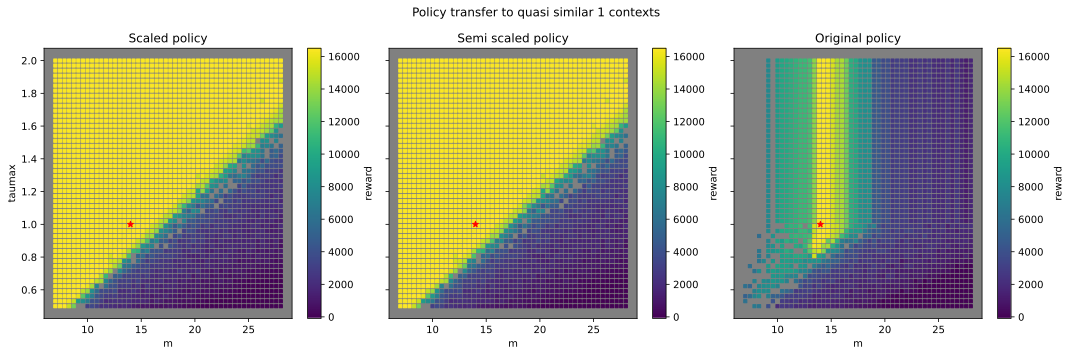

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

m0 = original_context.value("m")
tau0 = original_context.value("taumax")

norm = mpl.colors.Normalize(vmin=-100, vmax=16500)

quasi_similar_1_scaled_df.loc[quasi_similar_1_scaled_df["is_flipped"] == 0].plot.scatter("m", "taumax", c="reward", marker="s", s=10, norm=norm, ax=ax1)
# quasi_similar_1_scaled_df.plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax1)
ax1.scatter(m0, tau0, marker="*", c="r")
ax1.set_title("Scaled policy")
ax1.set_facecolor("grey")

quasi_similar_1_semi_scaled_df.loc[quasi_similar_1_semi_scaled_df["is_flipped"] == 0].plot.scatter("m", "taumax", c="reward", marker="s", s=10, norm=norm, ax=ax2)
# quasi_similar_1_semi_scaled_df.plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax2)
ax2.scatter(m0, tau0, marker="*", c="r")
ax2.set_title("Semi scaled policy")
ax2.set_facecolor("grey")

quasi_similar_1_naive_df.loc[quasi_similar_1_naive_df["is_flipped"] == 0].plot.scatter("m", "taumax", c="reward", marker="s", s=10, norm=norm, ax=ax3)
# quasi_similar_1_naive_df.plot.scatter("m", "taumax", c="reward", marker="s", s=50, norm=norm, ax=ax3)
ax3.scatter(m0, tau0, marker="*", c="r")
ax3.set_title("Original policy")
ax3.set_facecolor("grey")

fig.suptitle("Policy transfer to quasi similar 1 contexts")
fig.set_tight_layout(True)

## Quasi similar transfer 2

### Data generation

In [46]:
def context_fn(context):
    b1 = context.value(base[0])
    b2 = context.value(base[1])
    b3 = context.value(base[2])
    distance = context.adimensional_distance(original_context, base)

    # change = [context.value("torso_pos_z")]
    change = []
    for sym in quasi_similar_2_change_sweep_desc.keys():
        if sym not in base:
            change.append(context.value(sym))

    return context, b1, b2, b3, *change, distance

In [47]:
# changed_symbols = ["torso_pos_z"]
changed_symbols = []
for sym in quasi_similar_2_change_sweep_desc.keys():
    if sym not in base:
        changed_symbols.append(sym)

columns = ["context", base[0], base[1], base[2], *changed_symbols, "distance", "reward", "fwd_reward", "ctrl_reward", "is_flipped"]

In [48]:
all_quasi_similar_2_contexts = []

similars = linsweep_scale_contexts(original_context, quasi_similar_2_scale_sweep_desc)
for context in similars:
    all_quasi_similar_2_contexts += linsweep_change_contexts(context, quasi_similar_2_change_sweep_desc)

#### Scaled

In [49]:
data_scaled = record_sweep(
    all_quasi_similar_2_contexts,
    make_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_similar_2_scaled_df = pd.DataFrame(columns=columns, data=data_scaled)
quasi_similar_2_scaled_df

context     m      l0     g  \
0     ((L, Dimension([0 1 0]), 0.25), (Lh, Dimension...  14.0  0.0725  9.81   
1     ((L, Dimension([0 1 0]), 0.2653061224489796), ...  14.0  0.0725  9.81   
2     ((L, Dimension([0 1 0]), 0.28061224489795916),...  14.0  0.0725  9.81   
3     ((L, Dimension([0 1 0]), 0.29591836734693877),...  14.0  0.0725  9.81   
4     ((L, Dimension([0 1 0]), 0.3112244897959184), ...  14.0  0.0725  9.81   
...                                                 ...   ...     ...   ...   
2495  ((L, Dimension([0 1 0]), 0.9387755102040816), ...  14.0  0.2900  9.81   
2496  ((L, Dimension([0 1 0]), 0.9540816326530612), ...  14.0  0.2900  9.81   
2497  ((L, Dimension([0 1 0]), 0.9693877551020408), ...  14.0  0.2900  9.81   
2498  ((L, Dimension([0 1 0]), 0.9846938775510203), ...  14.0  0.2900  9.81   
2499  ((L, Dimension([0 1 0]), 1.0), (Lh, Dimension(...  14.0  0.2900  9.81   

             L  distance        reward    fwd_reward  ctrl_reward  is_flipped  
0     0.250000  0.000000  16386.371999  16745.085120  -358.713121           0  
1     0.265306  0.211119  14639.360242  15020.142883  -380.782641           0  
2     0.280612  0.422238  12365.309656  12748.724267  -383.414611           0  
3     0.295918  0.633357  10048.994708  10440.179127  -391.184418           0  
4     0.311224  0.844476   9436.664987   9828.716490  -392.051503           0  
...        ...       ...           ...           ...          ...         ...  
2495  0.938776  0.211119  14611.818729  14984.609236  -372.790506           0  
2496  0.954082  0.158339  15977.811990  16337.443922  -359.631932           0  
2497  0.969388  0.105559  16219.916999  16579.621122  -359.704122           0  
2498  0.984694  0.052780  16347.294271  16706.348231  -359.053960           0  
2499  1.000000  0.000000  16386.371999  16745.085120  -358.713121           0  

[2500 rows x 10 columns]

In [50]:
quasi_similar_2_scaled_df.to_pickle(DATA / "quasi_similar_2_scaled.pkl.gz")

#### Semi scaled

In [51]:
data_semi_scaled = record_sweep(
    all_quasi_similar_2_contexts,
    make_semi_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_similar_2_semi_scaled_df = pd.DataFrame(columns=columns, data=data_semi_scaled)
quasi_similar_2_semi_scaled_df

context     m      l0     g  \
0     ((L, Dimension([0 1 0]), 0.25), (Lh, Dimension...  14.0  0.0725  9.81   
1     ((L, Dimension([0 1 0]), 0.2653061224489796), ...  14.0  0.0725  9.81   
2     ((L, Dimension([0 1 0]), 0.28061224489795916),...  14.0  0.0725  9.81   
3     ((L, Dimension([0 1 0]), 0.29591836734693877),...  14.0  0.0725  9.81   
4     ((L, Dimension([0 1 0]), 0.3112244897959184), ...  14.0  0.0725  9.81   
...                                                 ...   ...     ...   ...   
2495  ((L, Dimension([0 1 0]), 0.9387755102040816), ...  14.0  0.2900  9.81   
2496  ((L, Dimension([0 1 0]), 0.9540816326530612), ...  14.0  0.2900  9.81   
2497  ((L, Dimension([0 1 0]), 0.9693877551020408), ...  14.0  0.2900  9.81   
2498  ((L, Dimension([0 1 0]), 0.9846938775510203), ...  14.0  0.2900  9.81   
2499  ((L, Dimension([0 1 0]), 1.0), (Lh, Dimension(...  14.0  0.2900  9.81   

             L  distance       reward   fwd_reward  ctrl_reward  is_flipped  
0     0.250000  0.000000  1946.550666  2139.495166  -192.944501           1  
1     0.265306  0.211119   127.870450   165.110027   -37.239577           1  
2     0.280612  0.422238  2708.167344  3085.322990  -377.155645           0  
3     0.295918  0.633357  2658.890683  3031.504316  -372.613633           0  
4     0.311224  0.844476   784.650828   904.930393  -120.279565           1  
...        ...       ...          ...          ...          ...         ...  
2495  0.938776  0.211119  -144.966028   292.720458  -437.686487           0  
2496  0.954082  0.158339   386.949191   795.068386  -408.119195           0  
2497  0.969388  0.105559  -428.308143    28.607522  -456.915665           0  
2498  0.984694  0.052780  -246.232837   203.672672  -449.905509           0  
2499  1.000000  0.000000  -442.511453    14.548897  -457.060350           0  

[2500 rows x 10 columns]

In [52]:
quasi_similar_2_semi_scaled_df.to_pickle(DATA / "quasi_similar_2_semi_scaled.pkl.gz")

#### Naive

In [53]:
data_naive = record_sweep(
    all_quasi_similar_2_contexts,
    make_naive_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_similar_2_naive_df = pd.DataFrame(columns=columns, data=data_naive)
quasi_similar_2_naive_df

context     m      l0     g  \
0     ((L, Dimension([0 1 0]), 0.25), (Lh, Dimension...  14.0  0.0725  9.81   
1     ((L, Dimension([0 1 0]), 0.2653061224489796), ...  14.0  0.0725  9.81   
2     ((L, Dimension([0 1 0]), 0.28061224489795916),...  14.0  0.0725  9.81   
3     ((L, Dimension([0 1 0]), 0.29591836734693877),...  14.0  0.0725  9.81   
4     ((L, Dimension([0 1 0]), 0.3112244897959184), ...  14.0  0.0725  9.81   
...                                                 ...   ...     ...   ...   
2495  ((L, Dimension([0 1 0]), 0.9387755102040816), ...  14.0  0.2900  9.81   
2496  ((L, Dimension([0 1 0]), 0.9540816326530612), ...  14.0  0.2900  9.81   
2497  ((L, Dimension([0 1 0]), 0.9693877551020408), ...  14.0  0.2900  9.81   
2498  ((L, Dimension([0 1 0]), 0.9846938775510203), ...  14.0  0.2900  9.81   
2499  ((L, Dimension([0 1 0]), 1.0), (Lh, Dimension(...  14.0  0.2900  9.81   

             L  distance      reward   fwd_reward  ctrl_reward  is_flipped  
0     0.250000  0.000000  498.122762  2072.259164 -1574.136402           0  
1     0.265306  0.211119   28.806675   173.353724  -144.547049           1  
2     0.280612  0.422238  183.393751  1717.538654 -1534.144903           0  
3     0.295918  0.633357  670.222967  2212.291121 -1542.068154           0  
4     0.311224  0.844476  523.314825  2067.314899 -1544.000074           0  
...        ...       ...         ...          ...          ...         ...  
2495  0.938776  0.211119 -149.157157   -65.302081   -83.855076           0  
2496  0.954082  0.158339 -139.925785   -55.380440   -84.545345           0  
2497  0.969388  0.105559 -164.991200   -79.455856   -85.535344           0  
2498  0.984694  0.052780 -155.067954   -68.696461   -86.371493           0  
2499  1.000000  0.000000 -143.547993   -58.584428   -84.963565           0  

[2500 rows x 10 columns]

In [54]:
quasi_similar_2_naive_df.to_pickle(DATA / "quasi_similar_2_naive.pkl.gz")

### Analysis


In [15]:
quasi_similar_2_scaled_df = pd.read_pickle(DATA / "quasi_similar_2_scaled.pkl.gz")
quasi_similar_2_semi_scaled_df = pd.read_pickle(DATA / "quasi_similar_2_semi_scaled.pkl.gz")
quasi_similar_2_naive_df = pd.read_pickle(DATA / "quasi_similar_2_naive.pkl.gz")

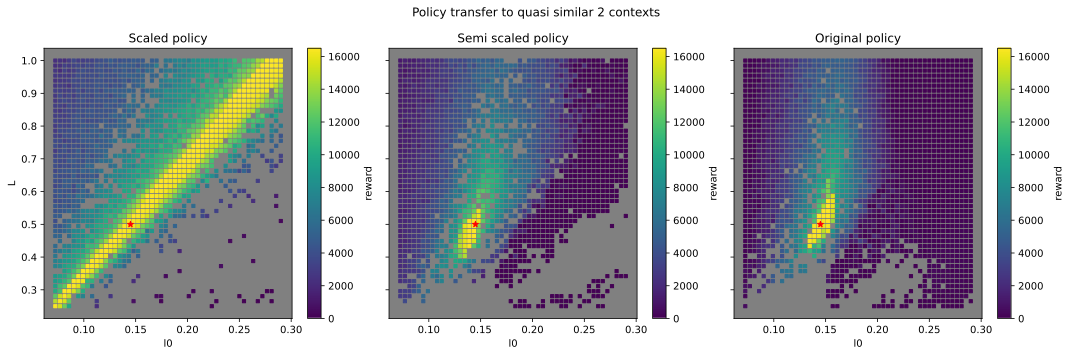

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

l0 = original_context.value("l0")
L = original_context.value("L")

norm = mpl.colors.Normalize(vmin=0, vmax=16500)

quasi_similar_2_scaled_df.loc[quasi_similar_2_scaled_df["is_flipped"] == 0].plot.scatter("l0", "L", c="reward", marker="s", s=10, norm=norm, ax=ax1)
# quasi_similar_2_scaled_df.plot.scatter("l0", "L", c="reward", marker="s", s=50, norm=norm, ax=ax1)
ax1.scatter(l0, L, marker="*", c="r")
ax1.set_title("Scaled policy")
ax1.set_facecolor("grey")

quasi_similar_2_semi_scaled_df.loc[quasi_similar_2_semi_scaled_df["is_flipped"] == 0].plot.scatter("l0", "L", c="reward", marker="s", s=10, norm=norm, ax=ax2)
# quasi_similar_2_semi_scaled_df.plot.scatter("l0", "L", c="reward", marker="s", s=50, norm=norm, ax=ax2)
ax2.scatter(l0, L, marker="*", c="r")
ax2.set_title("Semi scaled policy")
ax2.set_facecolor("grey")

quasi_similar_2_naive_df.loc[quasi_similar_2_naive_df["is_flipped"] == 0].plot.scatter("l0", "L", c="reward", marker="s", s=10, norm=norm, ax=ax3)
# quasi_similar_2_naive_df.plot.scatter("l0", "L", c="reward", marker="s", s=50, norm=norm, ax=ax3)
ax3.scatter(l0, L, marker="*", c="r")
ax3.set_title("Original policy")
ax3.set_facecolor("grey")

fig.suptitle("Policy transfer to quasi similar 2 contexts")
fig.set_tight_layout(True)

<!-- ## Non similar transfer -->

## Non similar transfer

### Data generation

In [ ]:
def context_fn(context):
    b1 = context.value(base[0])
    b2 = context.value(base[1])
    b3 = context.value(base[2])
    distance = context.adimensional_distance(original_context, base)

    return context, distance

In [ ]:
columns = ["context", "distance", "reward", "fwd_reward", "ctrl_reward", "is_flipped"]

In [ ]:
all_non_similar_contexts = []

for _ in range(nb_random_contexts):
    context = original_context.sample_around(lower, upper).change(
        forward_reward_weight=original_context.value("forward_reward_weight"),
        ctrl_cost_weight=original_context.value("ctrl_cost_weight"),
    )
    all_non_similar_contexts.append(context)

#### Scaled

In [ ]:
data_scaled = record_sweep(
    all_non_similar_contexts,
    make_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
non_similar_scaled_df = pd.DataFrame(columns=columns, data=data_scaled)
non_similar_scaled_df

context      distance  \
0     ((L, Dimension([0 1 0]), 44.111647607495975), ...  2.049158e+03   
1     ((L, Dimension([0 1 0]), 22.572360226820194), ...  2.425594e+03   
2     ((L, Dimension([0 1 0]), 33.83830026178371), (...  6.128648e+03   
3     ((L, Dimension([0 1 0]), 28.105424737498453), ...  2.894559e+04   
4     ((L, Dimension([0 1 0]), 56.05164346363049), (...  1.750450e+04   
...                                                 ...           ...   
2495  ((L, Dimension([0 1 0]), 25.512177529791998), ...  1.351195e+05   
2496  ((L, Dimension([0 1 0]), 51.62766625947134), (...  2.327604e+06   
2497  ((L, Dimension([0 1 0]), 58.76742608818803), (...  1.244857e+05   
2498  ((L, Dimension([0 1 0]), 68.57242093196541), (...  6.031485e+06   
2499  ((L, Dimension([0 1 0]), 44.822337882400625), ...  2.583454e+05   

            reward   fwd_reward   ctrl_reward  is_flipped  
0    -2.281980e+04  -108.882528 -2.271091e+04           0  
1    -2.021821e+04   -93.241881 -2.012496e+04           0  
2    -9.154619e+04  -291.085489 -9.125510e+04           0  
3    -3.556282e+05   -25.443157 -3.556028e+05           0  
4    -2.630064e+05    -0.171762 -2.630062e+05           0  
...            ...          ...           ...         ...  
2495 -1.254341e+06    10.372872 -1.254351e+06           0  
2496 -1.597796e+06 -1153.007662 -1.596643e+06           1  
2497 -1.880483e+06  -107.450740 -1.880375e+06           0  
2498 -9.083417e+06 -5471.937312 -9.077945e+06           1  
2499 -3.686416e+06  -103.963183 -3.686312e+06           0  

[2500 rows x 6 columns]

#### Semi scaled

In [ ]:
data_semi_scaled = record_sweep(
    all_non_similar_contexts,
    make_semi_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
non_similar_semi_scaled_df = pd.DataFrame(columns=columns, data=data_semi_scaled)
non_similar_semi_scaled_df

context      distance  \
0     ((L, Dimension([0 1 0]), 44.111647607495975), ...  2.049158e+03   
1     ((L, Dimension([0 1 0]), 22.572360226820194), ...  2.425594e+03   
2     ((L, Dimension([0 1 0]), 33.83830026178371), (...  6.128648e+03   
3     ((L, Dimension([0 1 0]), 28.105424737498453), ...  2.894559e+04   
4     ((L, Dimension([0 1 0]), 56.05164346363049), (...  1.750450e+04   
...                                                 ...           ...   
2495  ((L, Dimension([0 1 0]), 25.512177529791998), ...  1.351195e+05   
2496  ((L, Dimension([0 1 0]), 51.62766625947134), (...  2.327604e+06   
2497  ((L, Dimension([0 1 0]), 58.76742608818803), (...  1.244857e+05   
2498  ((L, Dimension([0 1 0]), 68.57242093196541), (...  6.031485e+06   
2499  ((L, Dimension([0 1 0]), 44.822337882400625), ...  2.583454e+05   

            reward    fwd_reward   ctrl_reward  is_flipped  
0    -2.702416e+04    -98.040246 -2.692612e+04           0  
1    -2.022167e+04    -91.235589 -2.013044e+04           0  
2    -9.303378e+04   -261.752849 -9.277203e+04           0  
3    -4.383467e+05    -83.517332 -4.382632e+05           0  
4    -2.652849e+05    -29.527478 -2.652554e+05           0  
...            ...           ...           ...         ...  
2495 -2.007740e+06   -119.695769 -2.007620e+06           0  
2496 -3.472374e+07  -1957.208818 -3.472178e+07           1  
2497 -1.882970e+06   -164.805317 -1.882805e+06           0  
2498 -9.101887e+07 -10384.199017 -9.100849e+07           1  
2499 -3.905753e+06    -95.494373 -3.905658e+06           0  

[2500 rows x 6 columns]

#### Naive

In [ ]:
data_naive = record_sweep(
    all_non_similar_contexts,
    make_naive_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
non_similar_naive_df = pd.DataFrame(columns=columns, data=data_naive)
non_similar_naive_df

context      distance  \
0     ((L, Dimension([0 1 0]), 44.111647607495975), ...  2.049158e+03   
1     ((L, Dimension([0 1 0]), 22.572360226820194), ...  2.425594e+03   
2     ((L, Dimension([0 1 0]), 33.83830026178371), (...  6.128648e+03   
3     ((L, Dimension([0 1 0]), 28.105424737498453), ...  2.894559e+04   
4     ((L, Dimension([0 1 0]), 56.05164346363049), (...  1.750450e+04   
...                                                 ...           ...   
2495  ((L, Dimension([0 1 0]), 25.512177529791998), ...  1.351195e+05   
2496  ((L, Dimension([0 1 0]), 51.62766625947134), (...  2.327604e+06   
2497  ((L, Dimension([0 1 0]), 58.76742608818803), (...  1.244857e+05   
2498  ((L, Dimension([0 1 0]), 68.57242093196541), (...  6.031485e+06   
2499  ((L, Dimension([0 1 0]), 44.822337882400625), ...  2.583454e+05   

           reward   fwd_reward  ctrl_reward  is_flipped  
0     -709.981407  -110.343162  -599.638245           0  
1     -688.691893   -89.029507  -599.662386           0  
2     -921.902786  -322.479545  -599.423241           0  
3     -609.020782    -9.483511  -599.537271           0  
4     -601.664254    -2.012919  -599.651336           0  
...           ...          ...          ...         ...  
2495  -357.409272   -20.883681  -336.525591           0  
2496 -1623.522720 -1024.664970  -598.857751           1  
2497  -690.944510   -91.349177  -599.595333           0  
2498 -9421.673100 -8824.178355  -597.494745           1  
2499  -690.907538   -91.693542  -599.213996           0  

[2500 rows x 6 columns]

### Analysis

<Axes: xlabel='distance', ylabel='fwd_reward'>

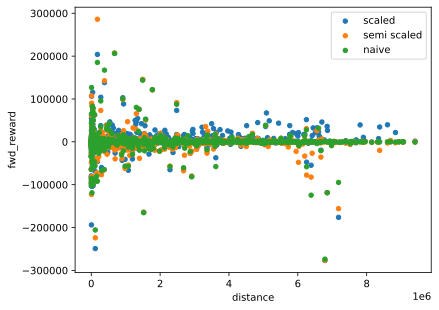

In [ ]:
fig, ax = plt.subplots()
non_similar_scaled_df.plot.scatter("distance", "fwd_reward", label="scaled", c="tab:blue", ax=ax)
non_similar_semi_scaled_df.plot.scatter("distance", "fwd_reward", label="semi scaled", c="tab:orange", ax=ax)
non_similar_naive_df.plot.scatter("distance", "fwd_reward", label="naive", c="tab:green", ax=ax)